# A4: Resume Parser

## 1. Load data

In [1]:
import numpy as np 
import pandas as pd
import spacy

In [2]:
df_resume = pd.read_csv('data/Resume.csv')

In [3]:
df_resume.head(5)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [5]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000,]
df_resume.shape

(1000, 4)

In [6]:
df_resume.Resume_str.values[:10]

array(['         HR & SAFETY MANAGER           Summary    Human Resources Manager Certified Professional in Human Resources (PHR) Extensive background in human resources management, including experience in workforce planning and employment, human resource development, compensation and benefits, risk management, employee and labor relations, HR technology, global and international HR, talent management. Demonstrated success in negotiating win-win situations, strategic business management, talent management, and change management. HR Skills HR Strategic Planning Training & Development Performance Management Organizational Development Mediation & Advocacy Staff Recruitment & Retention Employee Relations Alternative Dispute Resolution (ADR) Benefits Administration Project Management Orientation & On-Boarding HR Policies & Procedures Employment Law FMLA/ADA/EEO/WC HRIS Technologies           Experience      HR & Safety Manager    January 2013   to   January 2014     Company Name   －   City 

## 2. Load skill data (need to load others: experiences and certification, contact information)

In [7]:
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_md')

In [8]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

### add skill data

In [9]:
skill_path = 'data/skills.jsonl'

In [10]:
# Load skills from JSONL file
with open(skill_path, "r") as file:
    skills_data = [line.strip() for line in file]

skills = list(set(skills_data))
type(skills)

list

In [11]:
ruler = nlp.add_pipe("entity_ruler")

# add skills
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [12]:
# Define patterns for email addresses
email_patterns = [{"label": "EMAIL", "pattern": {"TEXT": {"REGEX": "[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\\.[a-zA-Z]{2,}"}}}]
ruler.add_patterns(email_patterns)

In [ ]:
# # add pattern
# patterns = [
#     {},
#     {"label": "label", "pattern": ""}
# ]
# ruler.add_pattern(patterns)

## 3. Cleaning Text

clean the dataset in a few steps:
- remove hyperlinks, special characters, or punctuations
- lowering text
- lemmatizing text to its base form for normalization
- removing english stopwords

In [13]:
# remove hyperlinks

import re

def remove_hyperlinks(sentence):
    
    #just in case there is hyperlink....
    sentence = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        sentence
    )
    
    return sentence

In [14]:
# clean the data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    
    # remove hyperlink
    sentence = remove_hyperlinks(sentence)
    
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and \
            token.pos_ != 'SYM' and token.pos_ != 'SPACE':
            clean_tokens.append(token.lemma_.lower().strip())
    
    return " ".join(clean_tokens)

In [15]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

## 4. Extract Information

### extract skills 
- extract skills, create a column called skills and append the unique skills to our dataset.
this is done for visualization.

In [19]:
# extract skills
def get_skills(text):
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
    
    return skills

In [20]:
# get the unique skills
def unique_skills(x):
    return list(set(x))

In [21]:
df_resume["skills"] = df_resume.Clean_resume.apply(get_skills)
df_resume["skills"] = df_resume.skills.apply(unique_skills)
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,skills
93,39970711,HR & SAFETY MANAGER Summary...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr safety manager summary human resources mana...,"[employee relations, discount, compensation, d..."
2426,25718772,TSO/FLOATER Career Overview ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,tso floater career overview to obtain position...,"[web, industrial engineering, network security..."
2055,14009087,INDEPENDENT PUBLIC RELATIONS CONSULTA...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,independent public relation consultant executi...,"[writer, marketing, web, skills, dreamweaver, ..."
79,29091445,HR ASSOCIATE MOBILIZATION COORDINATOR...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr associate mobilization coordinator summary ...,"[record, outlook, compensation, llc, timesheet..."
431,22968380,LEAD TEACHER Summary Use the...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,lead teacher summary use knowledge firsthand e...,"[language arts, prompt, website, perception, c..."


## 5. Visualization

In [26]:
# !pip3 install plotly

In [23]:
# import plotly.express as px

# fig = px.histogram(
#     df_resume, x="Category", title="Distribution of Jobs Categories"
# ).update_xaxes(categoryorder="total descending")
# fig.show()

In [24]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(49, 6)

In [29]:
all_skills = np.concatenate(df_resume_it.skills.values)

In [30]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))
counting

OrderedDict([('information technology', 48),
             ('system', 43),
             ('software', 42),
             ('it', 40),
             ('management', 38),
             ('technical', 36),
             ('project', 35),
             ('application', 35),
             ('technology', 34),
             ('security', 34)])

<BarContainer object of 10 artists>

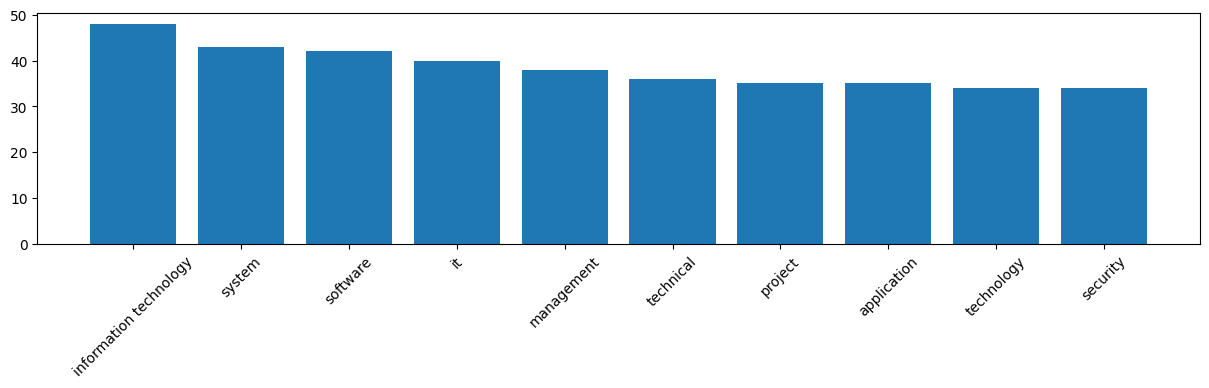

In [31]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15,3))
plt.xticks(rotation = 45)

plt.bar(counting.keys(),counting.values())

## 6. Name Entity Recognition

In [37]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

doc  = nlp(text)

colors  = {"SKILL": "linear-gradien(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc, style = 'ent', options=options)

## 7. load the PDF

In [35]:
from PyPDF2 import PdfReader
from spacy import displacy

In [34]:
reader = PdfReader("data/resume_dataset/accountant/10554236.pdf")
page   = reader.pages[0]
text   = page.extract_text()

In [36]:
text = preprocessing(text)
doc = nlp(text)

colors  = {"SKILL": "linear-gradien(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc, style = 'ent', options=options)